### Initialize notebook

In [1]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports

import os
import sys
sys.path.append('/home/ak/PycharmProjects/ature')
os.chdir('/home/ak/PycharmProjects/ature')


import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report
from neuralnet.utils.weights_utils import initialize_weights

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.hybridnet.hybridnet_trainer import SimpleNNTrainer
from neuralnet.hybridnet.hybridnet_dataloader import PatchesGenerator
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils

%load_ext autoreload
%autoreload 2

/home/ak/anaconda3/envs/ature_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

classes = { 'background': 0, 'vessel': 1,}
batch_size = 4
num_classes = len(classes)
epochs = 1
patch_rows = 51
rows, cols = 584, 565
use_gpu = False
pixel_offset = 5
#### Images to train/validate per epoch ####
train_size = None
validation_size = None
checkpoint_file = 'PytorchCheckpointHybridrow.nn.tar'

### Define the network

In [3]:
class Net(nn.Module):
    def __init__(self, input_width, input_height, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = input_width
        self.height = input_height
        print(self.width, self.height)
    
        self.kern_size = 7
        self.kern_stride = 1
        self.kern_padding = 3
        self.conv1 = nn.Conv2d(self.channels, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 5
        self.kern_stride = 1     
        self.kern_padding = 2
        self.conv2 = nn.Conv2d(64, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.conv3 = nn.Conv2d(64, 256, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 1
        self.kern_stride = 1      
        self.kern_padding = 0
        self.out = nn.Conv2d(256, num_classes, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        initialize_weights(self)
        print(self.width, self.height)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.out(x)
        return x
    
    def _get_output_size(self, w, f, p, s):       
        return ((w - f + 2 * p) / s) + 1


channels = 1
net = Net(rows, patch_rows, channels)
optimizer = optim.Adam(net.parameters(), lr=0.001)

584 51
584.0 51.0
584.0 51.0
584.0 51.0
584.0 51.0


### Load train data

In [4]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

trainset = PatchesGenerator(Dirs=Dirs, patch_rows=patch_rows, 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file, pixel_offset=pixel_offset, mode='train') 

# trainset.IDs = trainset.IDs[0:10]

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=3, 
                                          sampler=WeightedRandomSampler(np.ones(len(trainset.IDs)), train_size))

### 2201 patches found.


### Load Validation Data

In [5]:
transform_val = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

validation_set = PatchesGenerator(Dirs=ValidationDirs, patch_rows=patch_rows,  
                                       transform=transform_val,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file,pixel_offset=pixel_offset, mode='train') 

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=3,
                                            sampler=WeightedRandomSampler(np.ones(len(validation_set.IDs)), 
                                                                          validation_size, replacement=True))

### 220 patches found.


### Train and evaluate the Network

In [4]:
trainer = SimpleNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file)
trainer.resume_from_checkpoint()
# trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
#               validationloader=validationloader, force_checkpoint=True)
# trainer.resume_from_checkpoint()

Resumed last checkpoint: PytorchCheckpointHybridrow.nn.tar


### Test on a image

In [5]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = PatchesGenerator(Dirs=TestDirs, patch_rows=patch_rows, 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file,
                                 pixel_offset=patch_rows, mode='eval') 

sampler=WeightedRandomSampler(np.ones(testset.__len__()), 100000, replacement=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, 
                                          shuffle=False, num_workers=3, sampler=None)

### 11 patches found.


In [6]:
IJs, scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[2/2] pre:0.139 rec:0.871 f1:0.239 acc:0.952
[FINAL ::: Precision:0.388 Recall:0.886 F1:0.540 Acc:0.870]


### Convolve throughout the image to generate segmented image based on trained Network

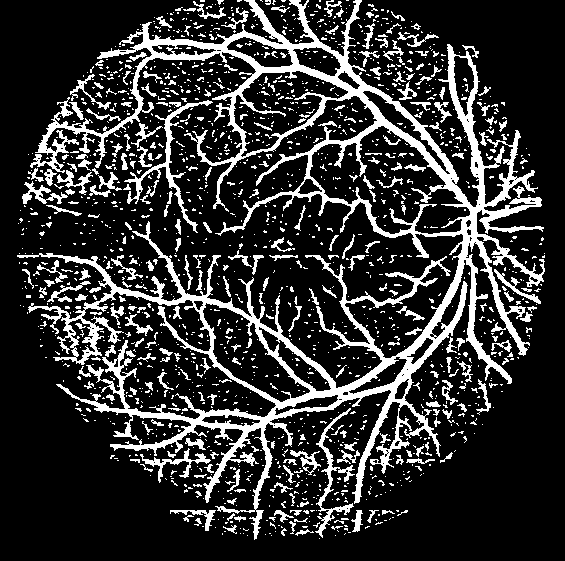

In [7]:
i = np.array(y_pred.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

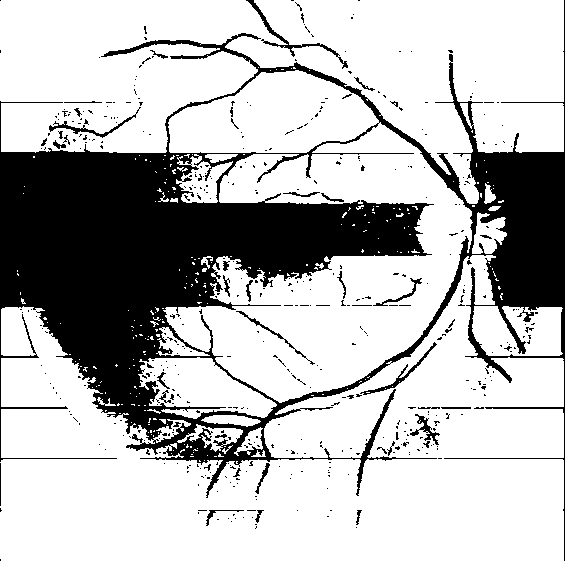

In [24]:
i = np.array(y_pred.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

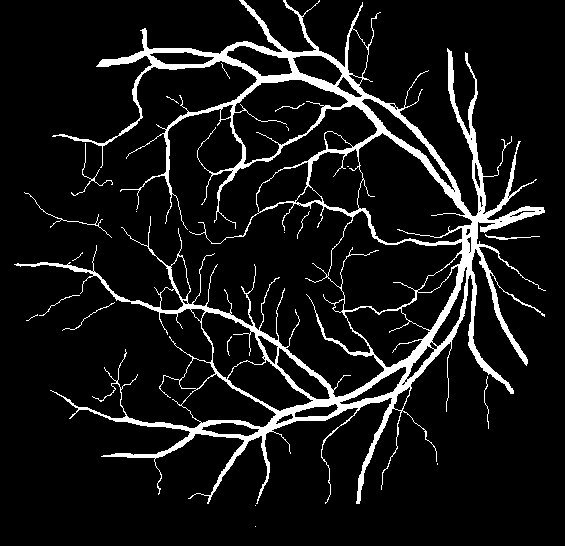

In [18]:
i = np.array(y_pred.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

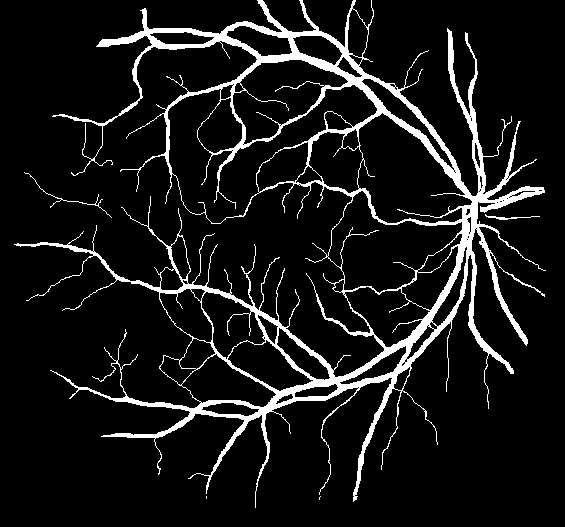

In [22]:
# IMG.fromarray(np.array(y_pred.reshape(584, 54/6)*255, dtype=np.uint8))
i = np.array(y_true.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

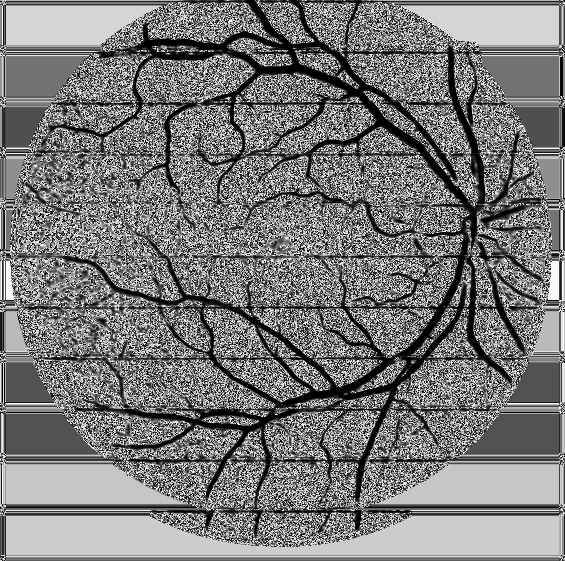

In [10]:
k = scores[:,0,:,:]
i = np.array(np.exp(k).reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

In [12]:
scores.shape

(17, 2, 31, 565)

In [ ]:
# params = {'sk_threshold': 150,
#           'alpha': 7.0,
#           'orig_contrib': 0.3,
#           'seg_threshold': 24}

# img_obj = SegmentedImage()

# img_obj.load_file(data_dir=TestDirs['images'], file_name=testset.images[0].file_name)
# img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
# # img_obj.working_arr = 255 - seg.astype(np.uint8)

# img_obj.load_mask(mask_dir=TestDirs['mask'], fget_mask=get_mask_file_test, erode=True)
# img_obj.load_ground_truth(gt_dir=TestDirs['truth'], fget_ground_truth=get_ground_truth_file)

# img_obj.generate_skeleton(threshold=params['sk_threshold'])
# img_obj.generate_lattice_graph()

In [ ]:
# tester = AtureTest(out_dir='')
# tester.run(params=params, save_images=False, img_obj=img_obj)
# img_obj.res['scores']

In [13]:
for c, i in enumerate(validation_set):
    x, y = i
    x = x.numpy()
    y = y.numpy()
    print(y.shape)
    if c==5:
        break

(51, 565)
(51, 565)
(51, 565)
(51, 565)
(51, 565)
(51, 565)


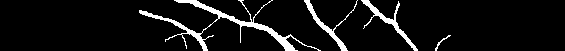

In [14]:
IMG.fromarray(np.array(y*255, dtype=np.uint8))

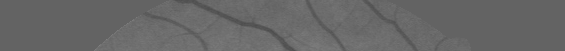

In [15]:
IMG.fromarray(np.array(x[0]*255, dtype=np.uint8))